In [1]:
import sys
import os
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_contrast_matrix
from nilearn.reporting import get_clusters_table
sys.path.append('..')
from utils.data import load_participant_list, get_betamap_paths, Subject, print_first_lvl_params

# Parameters

In [2]:
statistic = 'z_score'
multiple_comp_corr = 'fpr'
alpha = 0.05
run = 'test'
first_level_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/stim_category_20250428'
outpur_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/second_level/stim_category_20250428'

# First level parameters

In [3]:
print_first_lvl_params(first_level_dir)

model_name: stim_category
tr: 2.33384
hrf_model: spm
noise_model: ar1
smoothing_fwhm: 5
motion_type: basic
include_physio: True
brain_mask: True
fd_thresh: 0.5
std_dvars_thresh: 2
exclusion_threshold: 0.2
scrub: dummies
duration: all
iti_included: False


# Load First level data

In [4]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)

In [5]:
categories = ['face', 'house', 'hand', 'figure']

In [6]:
betamap_dict = {}
previous_found_subs = None

for cat in categories:
    betamap_paths, found_subs = get_betamap_paths(sub_ids, first_level_dir, run, f"sub-{{sub_id}}_run-{{run}}_betamap_first_stim_presentation_{cat}.nii.gz")
    betamap_dict[cat] = betamap_paths
    print(f"Found {len(betamap_paths)} beta maps for category {cat}")
    
    if previous_found_subs is None:
        previous_found_subs = found_subs
    else:
        if found_subs != previous_found_subs:
            print(f"Warning: found_subs list has changed for category {cat}")

Found 57 beta maps for category face
Found 57 beta maps for category house
Found 57 beta maps for category hand
Found 57 beta maps for category figure


In [7]:
all_paths = [path for paths in betamap_dict.values() for path in paths]

# Look at combined stim presentation

In [8]:
all_stim_presentation = [image.load_img(path) for path in all_paths]
X_sc = pd.DataFrame([1] * len(all_stim_presentation), columns=['intercept'])

In [9]:
second_level_model_sc = SecondLevelModel().fit(all_stim_presentation, design_matrix=X_sc)

In [10]:
SC_WB_zmap = second_level_model_sc.compute_contrast(output_type=statistic)

In [11]:
SC_WB_thresholded_map, SC_WB_threshold = threshold_stats_img(SC_WB_zmap, alpha=alpha, height_control='bonferroni')#, cluster_threshold=30)
print(f"RL whole brain threshold: {SC_WB_threshold:.3f}")

RL whole brain threshold: 4.957


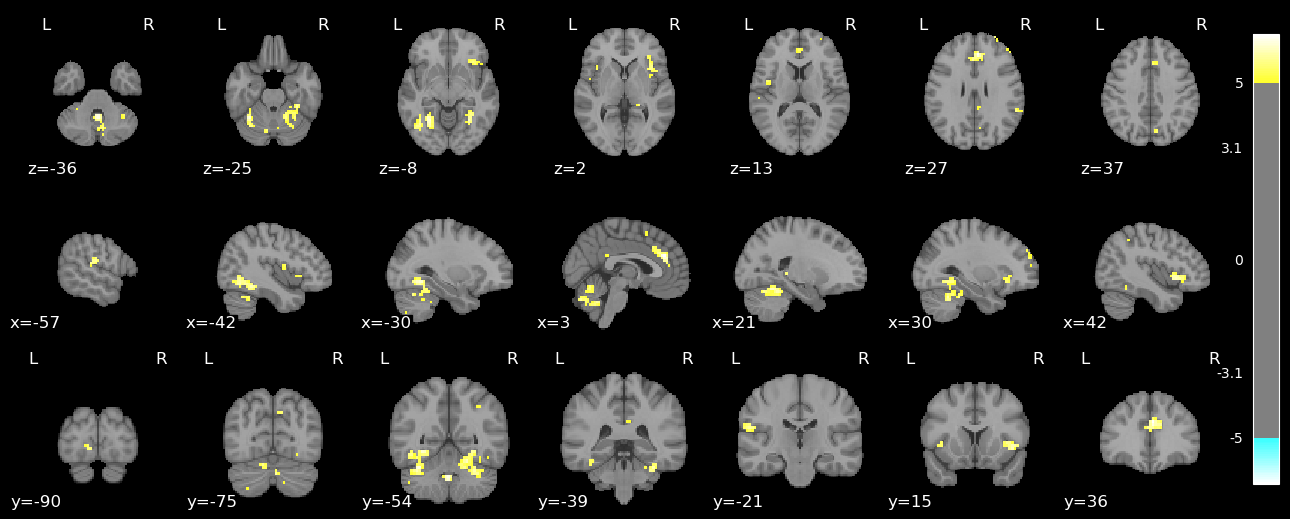

In [12]:
plot_stat_map(SC_WB_zmap, threshold=SC_WB_threshold, black_bg=True, display_mode='mosaic', title='')

# 2nd level model

In [13]:
# Stim 8 vs stim 1
face_imgs = [image.load_img(path) for path in betamap_dict['face']]
house_imgs = [image.load_img(path) for path in betamap_dict['house']]
hand_imgs = [image.load_img(path) for path in betamap_dict['hand']]
figure_imgs = [image.load_img(path) for path in betamap_dict['figure']]

# put all images together
all_imgs = face_imgs + house_imgs + hand_imgs + figure_imgs

conditions = ['face'] * len(face_imgs) + ['house'] * len(house_imgs) + ['hand'] * len(hand_imgs) + ['figure'] * len(figure_imgs)

X = pd.DataFrame({cat: [1 if c == cat else 0 for c in conditions] for cat in categories})
X['intercept'] = 1

<Axes: label='conditions', ylabel='scan number'>

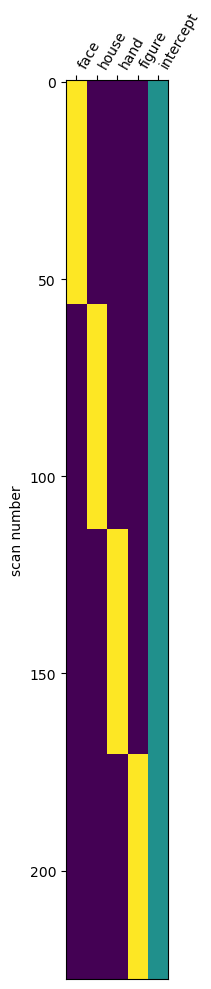

In [14]:
plot_design_matrix(X)

In [15]:
# Fit the second level model
second_level = SecondLevelModel().fit(all_imgs, design_matrix=X)

# Whole brain

In [16]:
z_maps_WB = {}

In [17]:
for cat in categories:
    z_maps_WB[cat] = second_level.compute_contrast(cat, output_type='z_score')
#z_maps_WB['mean_effect'] = second_level.compute_contrast('intercept', output_type='z_score')

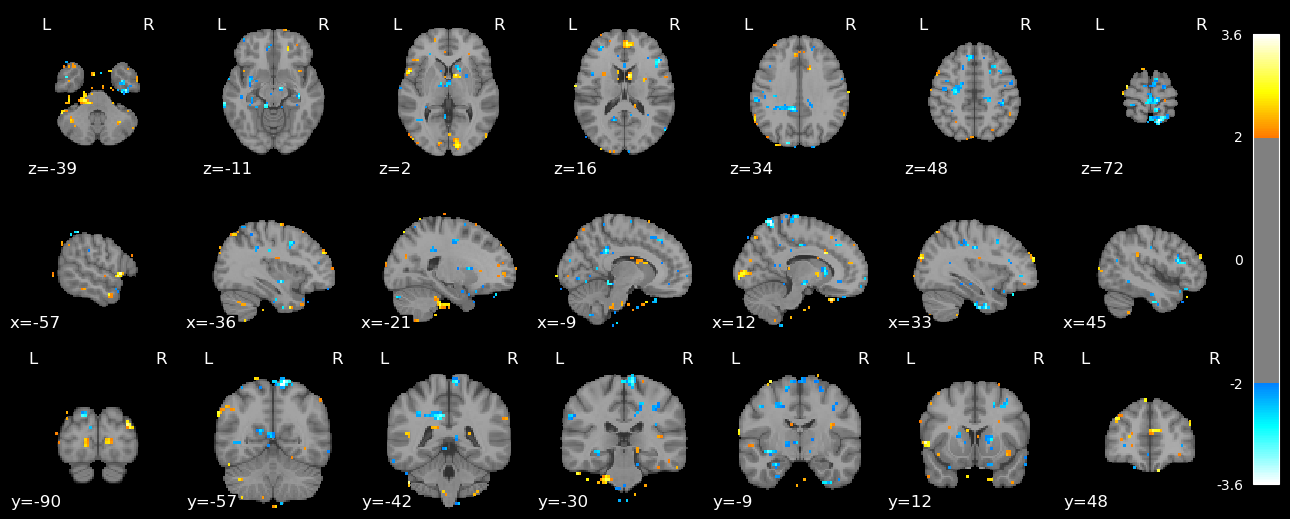

In [18]:
plot_stat_map(z_maps_WB['face'], threshold=2, black_bg=True, display_mode='mosaic')

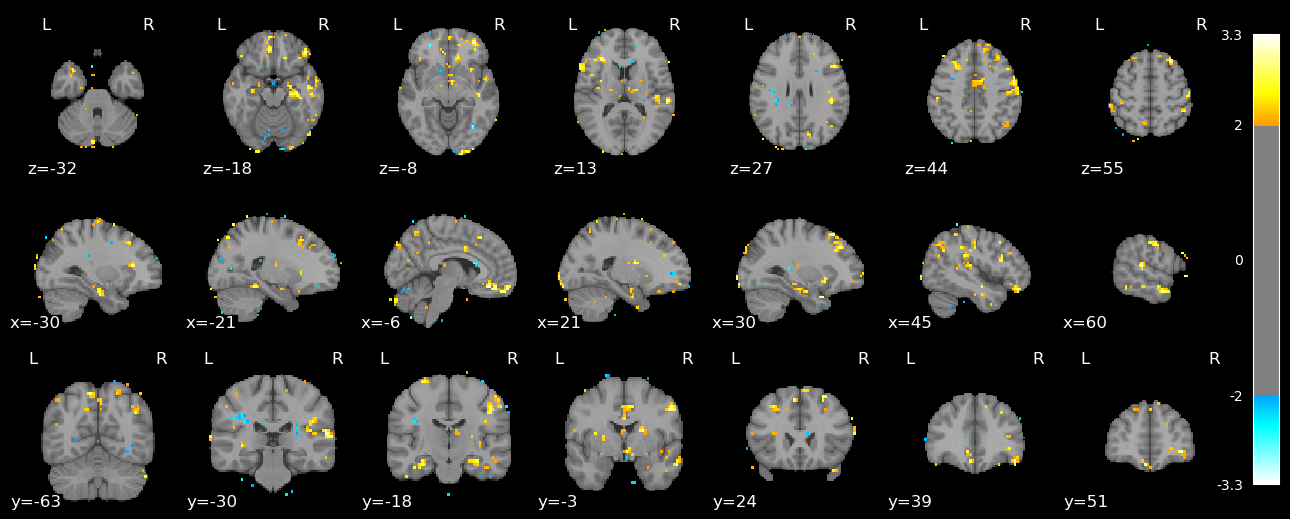

In [19]:
plot_stat_map(z_maps_WB['house'], threshold=2, black_bg=True, display_mode='mosaic')

# Fusiform area

In [20]:
mask_dir = '/home/ubuntu/data/learning-habits/masks'
fusiform_mask = os.path.join(mask_dir, 'fusiform_mask.nii.gz')
fusiform_mask = image.load_img(fusiform_mask)
fusiform_mask = image.resample_to_img(fusiform_mask, z_maps_WB['face'], interpolation='nearest') 

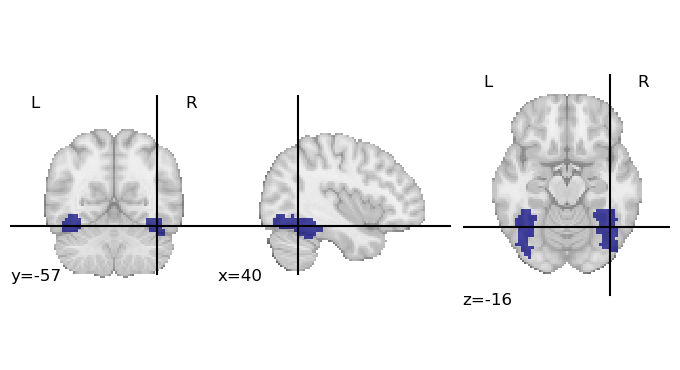

In [21]:
from nilearn.plotting import plot_roi
plot_roi(fusiform_mask)

In [22]:
ffa_second_lvl= SecondLevelModel(mask_img=fusiform_mask).fit(all_imgs, design_matrix=X)

In [23]:
ffa_face_zmap = ffa_second_lvl.compute_contrast('face',output_type=statistic)

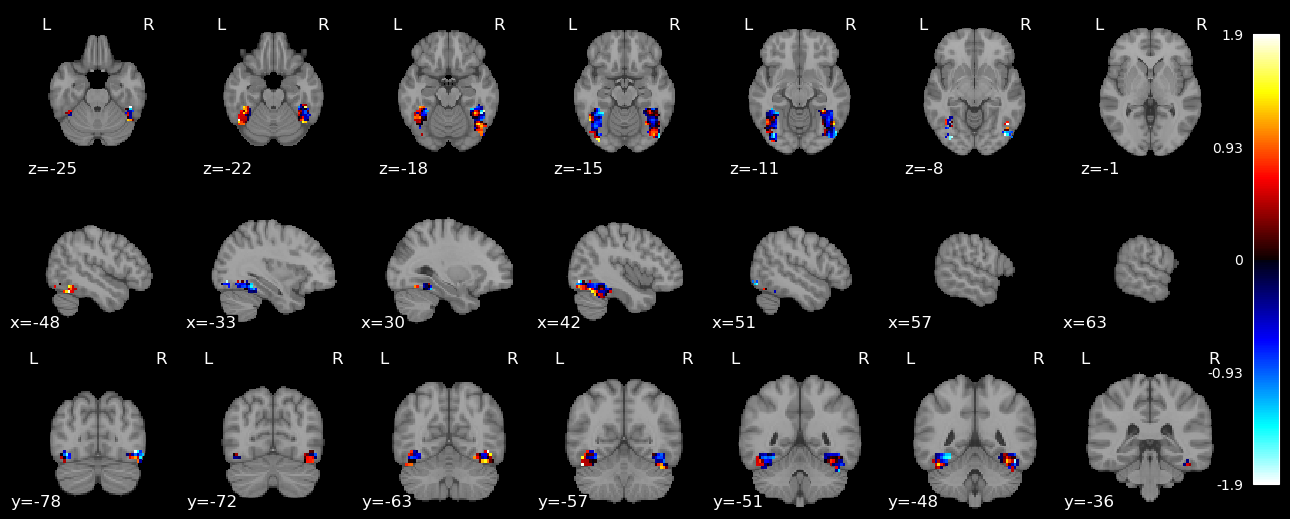

In [24]:
plot_stat_map(ffa_face_zmap, black_bg=True, display_mode='mosaic', title='')

In [25]:
ffa_face_thresholded_zmap, ffa_face_threshold = threshold_stats_img(ffa_face_zmap, alpha=0.001, height_control='fpr',
                                                                    two_sided=False)
print(f"FFA face threshold: {ffa_face_threshold:.3f}")

FFA face threshold: 3.090


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 1.8544602120069842. But, you have given threshold=3.090232306167813.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


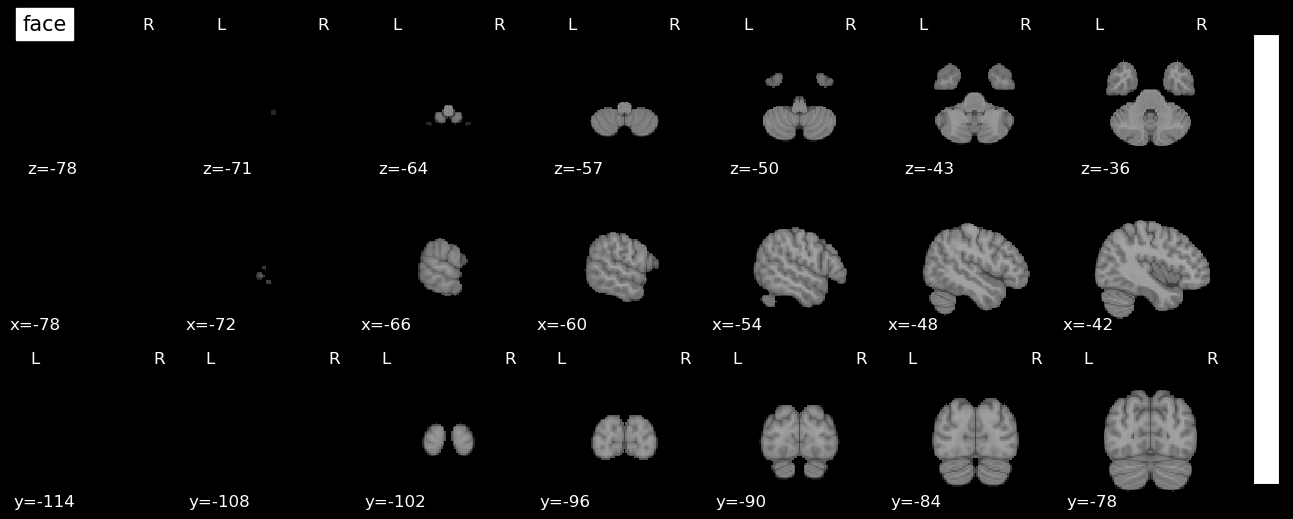

In [26]:
plot_stat_map(ffa_face_thresholded_zmap, threshold=ffa_face_threshold,
               black_bg=True, display_mode='mosaic', title='face')

# Other category for comparison

In [27]:
ffa_house_zmap = ffa_second_lvl.compute_contrast('house',output_type=statistic)

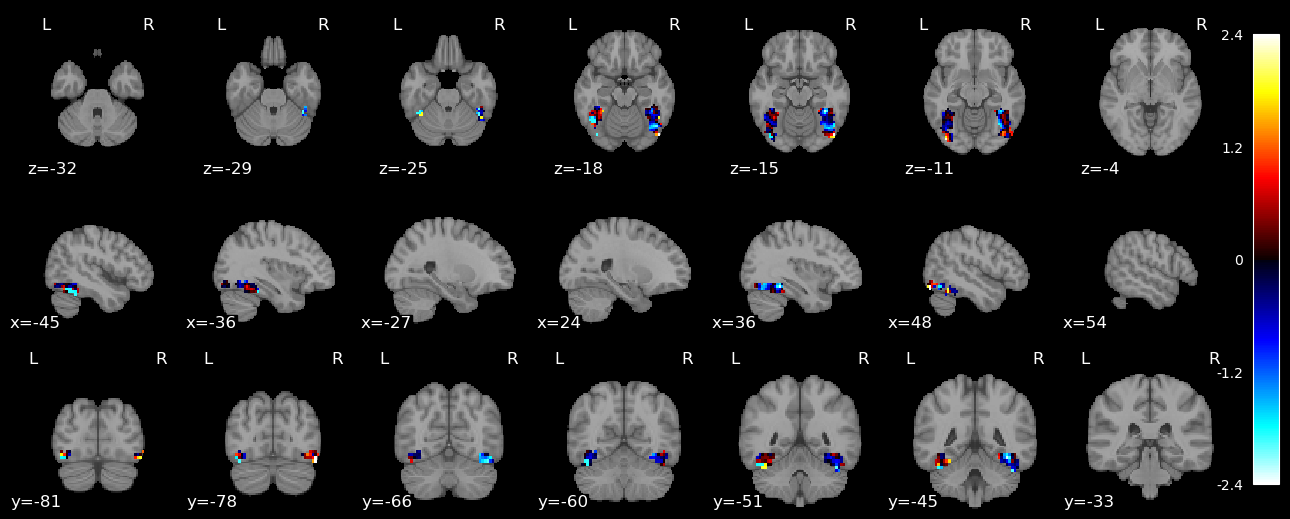

In [28]:
plot_stat_map(ffa_house_zmap, black_bg=True, display_mode='mosaic', title='')

In [29]:
ffa_hand_zmap = ffa_second_lvl.compute_contrast('hand',output_type=statistic)

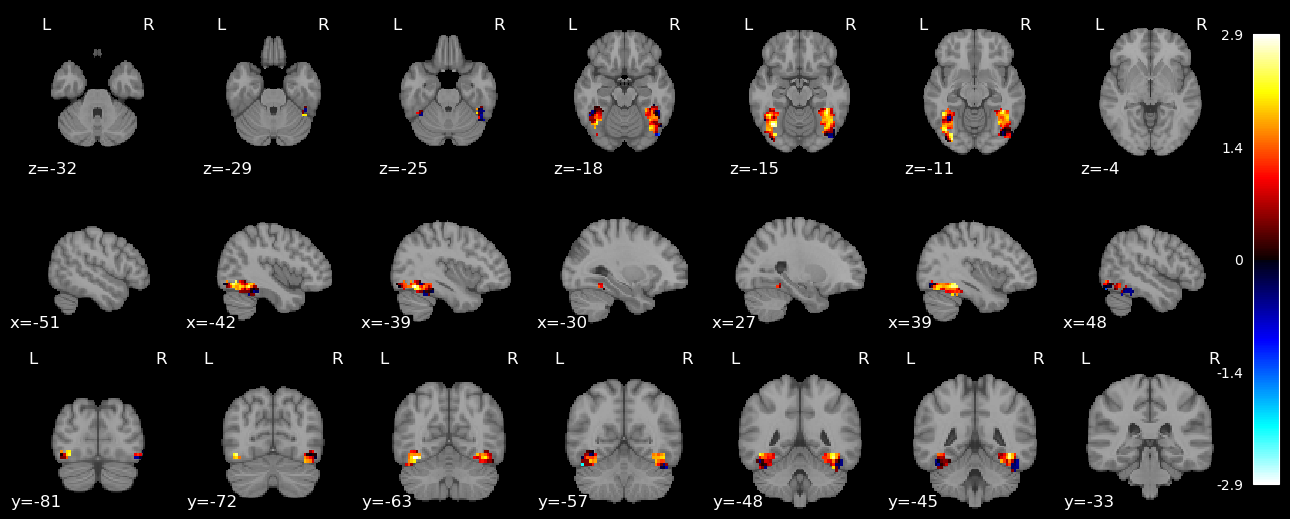

In [30]:
plot_stat_map(ffa_hand_zmap, black_bg=True, display_mode='mosaic', title='')